<h2><center>Analyzing Location data for suggesting a new Bar - Python Data Science</center></h2>

---

<div class="section-inner sectionLayout--insetColumn">
<h3 name="fdbd" class="graf graf--h3 graf--leading">
<strong class="markup--strong markup--h3-strong">The Business Plan&#8202;—&#8202;Short summary:</strong></h3>
<p name="ca01" class="graf graf--p graf-after--h3">

For this project, I am going to utilize the Foursquare API for referencing
<strong class="markup--strong markup--p-strong">location data in the Boston, MA</strong> area.
This data will allow us to report on and provide feedback to interested parties
<strong class="markup--strong markup--p-strong">looking to open a bar</strong>.</p>


### Getting Started

In [1]:
# import the proper libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
import jmespath

import json # library to handle JSON files
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
from sklearn.metrics import silhouette_score

print('Libraries imported.')


Libraries imported.


#### Download and Explore Dataset

In [2]:
import wget

## GeoJSON Data
# wget.download(
#     'http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson?outSR={%22latestWkid%22:2249,%22wkid%22:102686}',
#     'boston_data.json'
# )

In [3]:
with open('boston_data.json') as json_data:
    boston_data = json.load(json_data)

### A Quick look at the map of the GeoJSON datafile on a map using folium

In [4]:
boston_map = folium.Map(location=[42.329143, -71.076449], zoom_start=11)
boston_map.choropleth(
    geo_data=boston_data
)

# display map
boston_map

d:\github\.virtualenvs\coursera\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


Looking at the raw data, the **features** key holds the relevant neighborhood data.

In [5]:
boston_neighborhoods = boston_data['features']

#### Transform the data into a *pandas* dataframe

In [6]:
# define the dataframe columns
column_names = ['Neighborhood', 'SqMiles','Latitude', 'Longitude']

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Let's loop through the data and fill the dataframe one row at a time.

In [7]:
for data in boston_neighborhoods:
    neighborhood_name = data['properties']['Name']
    neighborhood_size = data['properties']['SqMiles']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon
    neighborhood_lon = neighborhood_latlon

    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'SqMiles': neighborhood_size,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [8]:
neighborhoods.head()

,Neighborhood,SqMiles,Latitude,Longitude
0,Roslindale,2.51,"[[[[-71.12592717485386, 42.272013107957406], [...","[[[[-71.12592717485386, 42.272013107957406], [..."
1,Jamaica Plain,3.94,"[[[-71.10499218689807, 42.326101682808066], [-...","[[[-71.10499218689807, 42.326101682808066], [-..."
2,Mission Hill,0.55,"[[[-71.0904343142608, 42.33576996328494], [-71...","[[[-71.0904343142608, 42.33576996328494], [-71..."
3,Longwood,0.29,"[[[-71.09810894210769, 42.33673037764089], [-7...","[[[-71.09810894210769, 42.33673037764089], [-7..."
4,Bay Village,0.04,"[[[-71.06662924918761, 42.34878268384542], [-7...","[[[-71.06662924918761, 42.34878268384542], [-7..."


Since the data downloaded came in a MultiPolygon geometry feature for the coordinates, we will want to convert
the coordinates to a single Point using the geojson library.

In [9]:
# Query the results you want from the json dataset,
# and in this case we have neighborhoods with different size arrays so multiple queries are needed

query = """
[*].{
Neighborhood: properties.Name,
SqMiles: properties.SqMiles,
Latitude: geometry.coordinates[0][0][0][1],
Longitude: geometry.coordinates[0][0][0][0]
}
"""

query2 = """
[*].{
Neighborhood: properties.Name,
SqMiles: properties.SqMiles,
Latitude: geometry.coordinates[0][0][1],
Longitude: geometry.coordinates[0][0][0]
}
"""

compiled = jmespath.compile(query)
results = compiled.search(boston_neighborhoods)
new_neighborhoods_df = pd.DataFrame.from_records(results)

compiled2 = jmespath.compile(query2)
results2 = compiled2.search(boston_neighborhoods)
new_neighborhoods_df2 = pd.DataFrame.from_records(results2)

# Merge the two dataframes created from the above queries
merged_neighborhood_df = pd.merge(new_neighborhoods_df, new_neighborhoods_df2,
                                 on='Neighborhood')

# Using the Mask function, we can drop all the null values of the merged dataframes and combine all data
# columns by the specific column name
merged_neighborhood_df['Latitude'] = merged_neighborhood_df['Latitude_x'].mask(
    pd.isnull, merged_neighborhood_df['Latitude_y'])
merged_neighborhood_df['Longitude'] = merged_neighborhood_df['Longitude_x'].mask(
    pd.isnull, merged_neighborhood_df['Longitude_y'])
merged_neighborhood_df['SqMiles'] = merged_neighborhood_df['SqMiles_x'].mask(
    pd.isnull, merged_neighborhood_df['SqMiles_y'])

# create a final dataframe with the previously given column names, for a clean dataset
final_neighborhood_df = merged_neighborhood_df[column_names]
final_neighborhood_df.head(10)

,Neighborhood,SqMiles,Latitude,Longitude
0,Roslindale,2.51,42.272,-71.1259
1,Jamaica Plain,3.94,42.3261,-71.105
2,Mission Hill,0.55,42.3358,-71.0904
3,Longwood,0.29,42.3367,-71.0981
4,Bay Village,0.04,42.3488,-71.0666
5,Leather District,0.02,42.3498,-71.0584
6,Chinatown,0.12,42.3524,-71.0579
7,North End,0.20,42.3688,-71.052
8,Roxbury,3.29,42.2932,-71.0965
9,South End,0.74,42.3478,-71.0683


Get a count of the total number of neighborhoods in Boston

In [10]:
print('Boston has a total of {} neighborhoods.'.format(
        len(final_neighborhood_df['Neighborhood'].unique())
))

print(final_neighborhood_df['Neighborhood'].unique())

Boston has a total of 26 neighborhoods.
['Roslindale' 'Jamaica Plain' 'Mission Hill' 'Longwood' 'Bay Village'
 'Leather District' 'Chinatown' 'North End' 'Roxbury' 'South End'
 'Back Bay' 'East Boston' 'Charlestown' 'West End' 'Beacon Hill'
 'Downtown' 'Fenway' 'Brighton' 'West Roxbury' 'Hyde Park' 'Mattapan'
 'Dorchester' 'South Boston Waterfront' 'South Boston' 'Allston'
 'Harbor Islands']


#### Using the geopy library to get the latitude and longitude values of Boston.

In order to define an instance of the geocoder, we need to define a user_agent. We
will name our agent <em>boston_explores</em>, as shown below.

In [11]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="boston_explores")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Boston are 42.3602534, -71.0582912.


#### Create a map of Boston with neighborhoods superimposed on top (defined by the neighborhood coordinates)

In [12]:
# create map of New York using latitude and longitude values
map_boston = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood_name, neighborhood in zip(final_neighborhood_df['Latitude'],
                                                     final_neighborhood_df['Longitude'],
                                                     final_neighborhood_df['Neighborhood'],
                                                     final_neighborhood_df['SqMiles']):
    label = '{}, {}'.format(neighborhood, neighborhood_name)
    label = folium.Popup(label, parse_html=True)
    # noinspection PyTypeChecker
    folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_boston)

map_boston

### Foursquare Analytics

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods
and segment them.

#### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = '23XKBQIHR43GO4QC5TUCSO2QLXJCLTVZDKRH5M4GIQXAS0HU' # your Foursquare ID
CLIENT_SECRET = 'E13CWP4V1MPUCBMGOMYPBD13LWUS2NPCHXRCQWZVE51FCK2P' # your Foursquare Secret
VERSION = '20120609' #Four-Square API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 23XKBQIHR43GO4QC5TUCSO2QLXJCLTVZDKRH5M4GIQXAS0HU
CLIENT_SECRET:E13CWP4V1MPUCBMGOMYPBD13LWUS2NPCHXRCQWZVE51FCK2P


#### Let's get the top 100, most popular venues that are in Boston within a .5 mile radius (804 meters).

In [14]:
def get_nearby_venues(names, latitudes, longitudes):
    venues_list = []
    radius = 804
    LIMIT = 100

    # noinspection PyShadowingNames
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = \
            'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                VERSION,
                lat,
                lng,
                radius,
                LIMIT)

        # make the GET request
        get_results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in get_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return nearby_venues

#### Now run the above function on each neighborhood and create a new dataframe called *boston_venues*.

In [15]:
boston_venues = get_nearby_venues(
    names=final_neighborhood_df['Neighborhood'],
    latitudes=final_neighborhood_df['Latitude'],
    longitudes=final_neighborhood_df['Longitude']

)

Roslindale
Jamaica Plain
Mission Hill
Longwood
Bay Village
Leather District
Chinatown
North End
Roxbury
South End
Back Bay
East Boston
Charlestown
West End
Beacon Hill
Downtown
Fenway
Brighton
West Roxbury
Hyde Park
Mattapan
Dorchester
South Boston Waterfront
South Boston
Allston
Harbor Islands


#### Now we want to filter for Bars/ pubs only

In [16]:
boston_bar_vens = boston_venues[boston_venues['Venue Category'].str.contains(
    'Bar|Pub')].reset_index(drop=True)
boston_bar_venues = boston_bar_vens[~boston_bar_vens['Venue Category'].str.contains(
    'Barbershop')].reset_index(drop=True)
boston_bar_venues.index = np.arange(1, len(boston_bar_venues) + 1)
boston_bar_venues['Venue Category'].value_counts()

Bar             28
Pub             14
Hotel Bar        9
Dive Bar         7
Wine Bar         7
Sports Bar       7
Juice Bar        6
Cocktail Bar     5
Tiki Bar         4
Irish Pub        2
Karaoke Bar      2
Gay Bar          2
Name: Venue Category, dtype: int64

#### Let's check the size of the resulting dataframe

In [17]:
print(boston_bar_venues.shape)
boston_bar_venues.head()

(93, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Jamaica Plain,42.326102,-71.104992,Brendan Behan Pub,42.322100,-71.109378,Pub
2,Mission Hill,42.335770,-71.090434,Slades Bar & Grill,42.337343,-71.083754,Sports Bar
3,Mission Hill,42.335770,-71.090434,Conor Larkin's,42.340769,-71.088202,Sports Bar
4,Longwood,42.336730,-71.098109,Puddingstone Tavern,42.333625,-71.103162,Bar
5,Longwood,42.336730,-71.098109,Flann O'Brien's,42.333781,-71.103243,Pub


Let's check how many venues were returned for each neighborhood

In [18]:
boston_bar_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,2,2,2,2,2,2
Back Bay,6,6,6,6,6,6
Bay Village,7,7,7,7,7,7
Beacon Hill,6,6,6,6,6,6
Brighton,2,2,2,2,2,2
Charlestown,4,4,4,4,4,4
Chinatown,4,4,4,4,4,4
Dorchester,2,2,2,2,2,2
Downtown,6,6,6,6,6,6


#### Let's find out how many unique categories can be curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(boston_bar_venues['Venue Category'].unique())))

There are 12 uniques categories.


## 3. Analyze Each Neighborhood

#### What are the most common venue categories in our 6 selected neighborhoods?

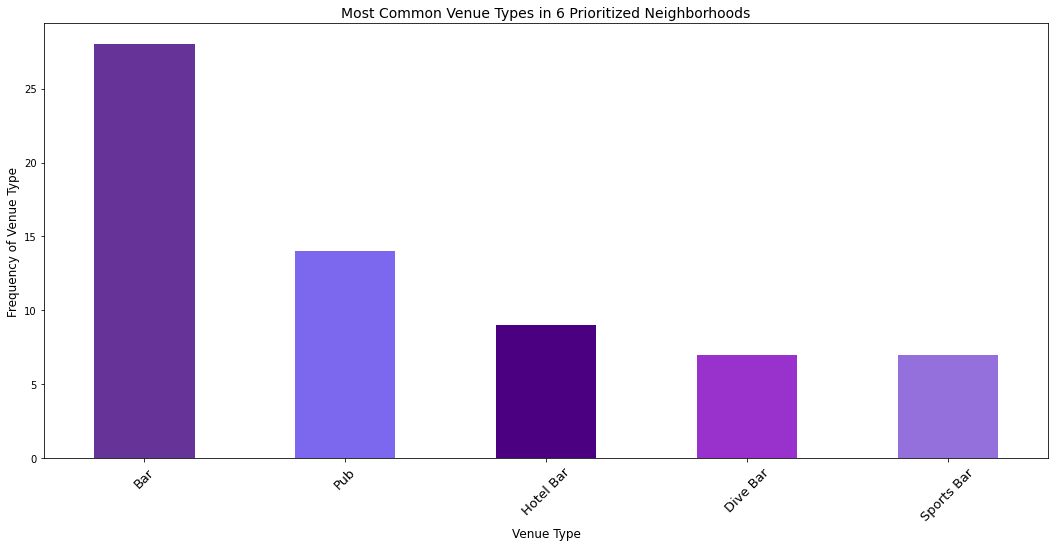

In [20]:
boston_top_venues = boston_bar_venues.groupby(
    'Venue Category', as_index = False).count().sort_values(
    'Neighborhood', ascending = False).head(5)
boston_top_venues = boston_top_venues[['Venue Category','Neighborhood']]
boston_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
boston_top_venues.plot.bar(
    x='Venue Category', y='Frequency',
    legend=None, title="Most common venue types in 6 prioritized neighborhoods",
    rot=45, figsize=(18, 8),
    color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])

plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most Common Venue Types in 6 Prioritized Neighborhoods', fontsize = 14)
plt.show()

In [21]:
# one hot encoding
boston_onehot = pd.get_dummies(boston_bar_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_bar_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.head()

,Neighborhood,Bar,Cocktail Bar,Dive Bar,Gay Bar,Hotel Bar,Irish Pub,Juice Bar,Karaoke Bar,Pub,Sports Bar,Tiki Bar,Wine Bar
1,Jamaica Plain,0,0,0,0,0,0,0,0,1,0,0,0
2,Mission Hill,0,0,0,0,0,0,0,0,0,1,0,0
3,Mission Hill,0,0,0,0,0,0,0,0,0,1,0,0
4,Longwood,1,0,0,0,0,0,0,0,0,0,0,0
5,Longwood,0,0,0,0,0,0,0,0,1,0,0,0


And let's examine the new dataframe size.

In [22]:
boston_onehot.shape

(93, 13)

#### Next, let's group rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [23]:
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()

# Confirm the new size:
print(boston_grouped.shape)
boston_grouped

(21, 13)


,Neighborhood,Bar,Cocktail Bar,Dive Bar,Gay Bar,Hotel Bar,Irish Pub,Juice Bar,Karaoke Bar,Pub,Sports Bar,Tiki Bar,Wine Bar
0,Allston,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Back Bay,0.166667,0.000000,0.000000,0.000000,0.500000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000
2,Bay Village,0.000000,0.142857,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.142857,0.285714
3,Beacon Hill,0.166667,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000
4,Brighton,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Charlestown,0.500000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
6,Chinatown,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.250000
7,Dorchester,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Downtown,0.500000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000
9,Fenway,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.500000,0.000000,0.000000,0.000000


#### Let's print each neighborhood along with the top 5 most common venues

In [24]:
num_top_venues = 10

for hood in boston_grouped['Neighborhood']:
    print("----" + hood + "----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
          venue  freq
0           Bar   1.0
1  Cocktail Bar   0.0
2      Dive Bar   0.0
3       Gay Bar   0.0
4     Hotel Bar   0.0
5     Irish Pub   0.0
6     Juice Bar   0.0
7   Karaoke Bar   0.0
8           Pub   0.0
9    Sports Bar   0.0


----Back Bay----
          venue  freq
0     Hotel Bar  0.50
1           Bar  0.17
2     Juice Bar  0.17
3           Pub  0.17
4  Cocktail Bar  0.00
5      Dive Bar  0.00
6       Gay Bar  0.00
7     Irish Pub  0.00
8   Karaoke Bar  0.00
9    Sports Bar  0.00


----Bay Village----
          venue  freq
0      Dive Bar  0.29
1      Wine Bar  0.29
2  Cocktail Bar  0.14
3           Pub  0.14
4      Tiki Bar  0.14
5           Bar  0.00
6       Gay Bar  0.00
7     Hotel Bar  0.00
8     Irish Pub  0.00
9     Juice Bar  0.00


----Beacon Hill----
          venue  freq
0     Hotel Bar  0.67
1           Bar  0.17
2           Pub  0.17
3  Cocktail Bar  0.00
4      Dive Bar  0.00
5       Gay Bar  0.00
6     Irish Pub  0.00
7     Juice Bar  0.

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 bars for each neighborhood.

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = \
        return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
1,Back Bay,Hotel Bar,Pub,Juice Bar,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Irish Pub,Gay Bar
2,Bay Village,Wine Bar,Dive Bar,Tiki Bar,Pub,Cocktail Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar
3,Beacon Hill,Hotel Bar,Pub,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Gay Bar
4,Brighton,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
5,Charlestown,Bar,Sports Bar,Cocktail Bar,Wine Bar,Tiki Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar
6,Chinatown,Wine Bar,Pub,Karaoke Bar,Dive Bar,Tiki Bar,Sports Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
7,Dorchester,Dive Bar,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar
8,Downtown,Bar,Pub,Irish Pub,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Hotel Bar,Gay Bar
9,Fenway,Pub,Juice Bar,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Irish Pub,Hotel Bar,Gay Bar


## 4. Cluster Neighborhoods

In [27]:
boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

d:\github\.virtualenvs\coursera\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


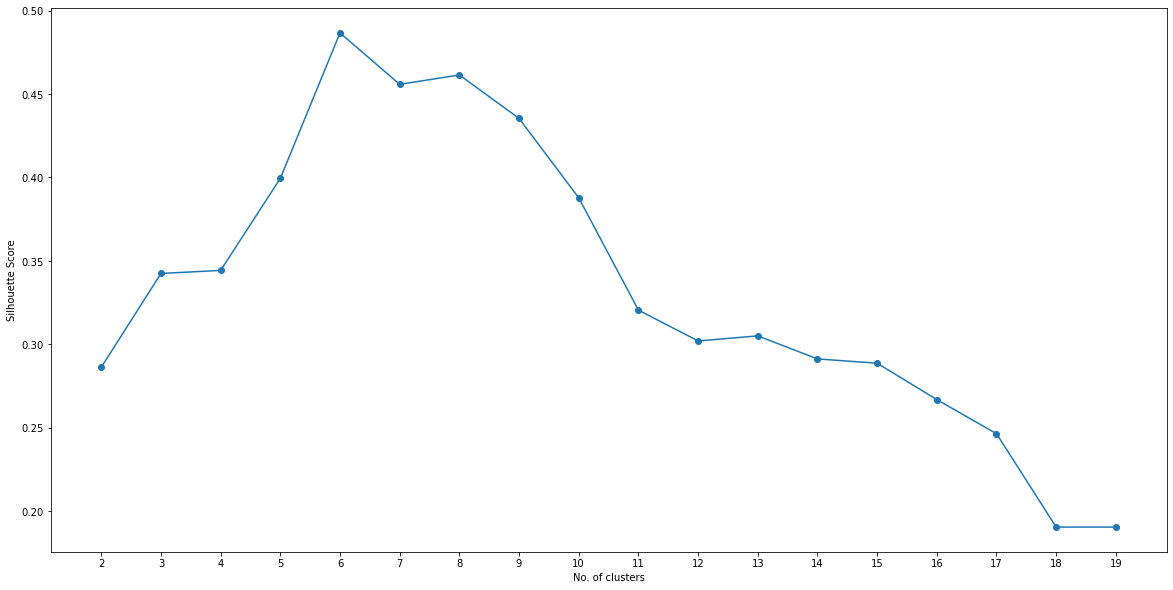

In [28]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

indices = []
scores = []
max_range = 20

for kclusters in range(2, max_range) :

    # Run k-means clustering
    bct = boston_grouped_clustering
    kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=0).fit_predict(bct)

    # Gets the score for the clustering operation performed
    score = silhouette_score(bct, kmeans)

    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)


plot(max_range, scores, "No. of clusters", "Silhouette Score")

### Using the graph above, we now have the optimal number for clustering consideration

In [29]:
opt_cluster = np.argmax(scores) + 2  # Used to find the optimal value
opt_cluster

6

In [30]:
# set number of clusters
kclusters = opt_cluster

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 4, 1, 0, 2, 4, 2, 2, 5])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Bars and Pubs', kmeans.labels_)
boston_merged = final_neighborhood_df

# merge boston_grouped with venue_data to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),
                                   on='Neighborhood')

boston_merged

,Neighborhood,SqMiles,Latitude,Longitude,Bars and Pubs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Roslindale,2.51,42.272,-71.1259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jamaica Plain,3.94,42.3261,-71.105,5.0,Pub,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar
2,Mission Hill,0.55,42.3358,-71.0904,3.0,Sports Bar,Wine Bar,Tiki Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar
3,Longwood,0.29,42.3367,-71.0981,2.0,Pub,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
4,Bay Village,0.04,42.3488,-71.0666,4.0,Wine Bar,Dive Bar,Tiki Bar,Pub,Cocktail Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar
5,Leather District,0.02,42.3498,-71.0584,4.0,Dive Bar,Wine Bar,Tiki Bar,Karaoke Bar,Cocktail Bar,Sports Bar,Pub,Juice Bar,Irish Pub,Hotel Bar
6,Chinatown,0.12,42.3524,-71.0579,4.0,Wine Bar,Pub,Karaoke Bar,Dive Bar,Tiki Bar,Sports Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
7,North End,0.20,42.3688,-71.052,3.0,Sports Bar,Juice Bar,Wine Bar,Tiki Bar,Pub,Karaoke Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar
8,Roxbury,3.29,42.2932,-71.0965,0.0,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
9,South End,0.74,42.3478,-71.0683,4.0,Wine Bar,Juice Bar,Tiki Bar,Pub,Gay Bar,Dive Bar,Cocktail Bar,Sports Bar,Karaoke Bar,Irish Pub


Clean up the neighborhoods with no data for bars

In [32]:
boston_merged = boston_merged.dropna(inplace=False)
boston_merged

,Neighborhood,SqMiles,Latitude,Longitude,Bars and Pubs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Jamaica Plain,3.94,42.3261,-71.105,5.0,Pub,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar
2,Mission Hill,0.55,42.3358,-71.0904,3.0,Sports Bar,Wine Bar,Tiki Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar
3,Longwood,0.29,42.3367,-71.0981,2.0,Pub,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
4,Bay Village,0.04,42.3488,-71.0666,4.0,Wine Bar,Dive Bar,Tiki Bar,Pub,Cocktail Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar
5,Leather District,0.02,42.3498,-71.0584,4.0,Dive Bar,Wine Bar,Tiki Bar,Karaoke Bar,Cocktail Bar,Sports Bar,Pub,Juice Bar,Irish Pub,Hotel Bar
6,Chinatown,0.12,42.3524,-71.0579,4.0,Wine Bar,Pub,Karaoke Bar,Dive Bar,Tiki Bar,Sports Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
7,North End,0.20,42.3688,-71.052,3.0,Sports Bar,Juice Bar,Wine Bar,Tiki Bar,Pub,Karaoke Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar
8,Roxbury,3.29,42.2932,-71.0965,0.0,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
9,South End,0.74,42.3478,-71.0683,4.0,Wine Bar,Juice Bar,Tiki Bar,Pub,Gay Bar,Dive Bar,Cocktail Bar,Sports Bar,Karaoke Bar,Irish Pub
10,Back Bay,0.62,42.3569,-71.0757,1.0,Hotel Bar,Pub,Juice Bar,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Irish Pub,Gay Bar


#### Finally, let's visualize the resulting clusters

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
# noinspection PyUnresolvedReferences
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        boston_merged['Latitude'],
        boston_merged['Longitude'],
        boston_merged['Neighborhood'],
        boston_merged['Bars and Pubs']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    # noinspection PyTypeChecker
    folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster - 1)],
            fill=True,
            fill_color=rainbow[int(cluster - 1)],
            fill_opacity=0.7).add_to(map_clusters)

map_clusters

## 5. Examine Clusters

Examine each cluster and determine the discriminating venue categories that
distinguish each cluster.

#### Cluster 1

In [34]:
cl1 = boston_merged.loc[boston_merged['Bars and Pubs']
                        == 0, boston_merged.columns[[0] + list(range(5, boston_merged.shape[1]))]]
cl1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Roxbury,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
17,Brighton,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
20,Mattapan,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
24,Allston,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar


#### Cluster 2

In [35]:
cl2 = boston_merged.loc[boston_merged['Bars and Pubs']
                        == 1, boston_merged.columns[[0] + list(range(5, boston_merged.shape[1]))]]
cl2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Back Bay,Hotel Bar,Pub,Juice Bar,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Irish Pub,Gay Bar
14,Beacon Hill,Hotel Bar,Pub,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Gay Bar


#### Cluster 3

In [36]:
cl3 = boston_merged.loc[boston_merged['Bars and Pubs']
                        == 2, boston_merged.columns[[0] + list(range(5, boston_merged.shape[1]))]]
cl3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Longwood,Pub,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
12,Charlestown,Bar,Sports Bar,Cocktail Bar,Wine Bar,Tiki Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar
13,West End,Bar,Sports Bar,Pub,Irish Pub,Wine Bar,Tiki Bar,Karaoke Bar,Juice Bar,Hotel Bar,Gay Bar
15,Downtown,Bar,Pub,Irish Pub,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Hotel Bar,Gay Bar
21,Dorchester,Dive Bar,Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar
22,South Boston Waterfront,Bar,Hotel Bar,Juice Bar,Cocktail Bar,Wine Bar,Tiki Bar,Sports Bar,Pub,Karaoke Bar,Irish Pub
23,South Boston,Bar,Tiki Bar,Pub,Gay Bar,Wine Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar


#### Cluster 4

In [37]:
cl4 = boston_merged.loc[boston_merged['Bars and Pubs']
                        == 3, boston_merged.columns[[0] + list(range(5, boston_merged.shape[1]))]]
cl4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Mission Hill,Sports Bar,Wine Bar,Tiki Bar,Pub,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar
7,North End,Sports Bar,Juice Bar,Wine Bar,Tiki Bar,Pub,Karaoke Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar


#### Cluster 5

In [38]:
cl5 = boston_merged.loc[boston_merged['Bars and Pubs']
                        == 4, boston_merged.columns[[0] + list(range(5, boston_merged.shape[1]))]]
cl5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bay Village,Wine Bar,Dive Bar,Tiki Bar,Pub,Cocktail Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar
5,Leather District,Dive Bar,Wine Bar,Tiki Bar,Karaoke Bar,Cocktail Bar,Sports Bar,Pub,Juice Bar,Irish Pub,Hotel Bar
6,Chinatown,Wine Bar,Pub,Karaoke Bar,Dive Bar,Tiki Bar,Sports Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar
9,South End,Wine Bar,Juice Bar,Tiki Bar,Pub,Gay Bar,Dive Bar,Cocktail Bar,Sports Bar,Karaoke Bar,Irish Pub


#### Cluster 6

In [39]:
cl6 = boston_merged.loc[boston_merged['Bars and Pubs']
                        == 5, boston_merged.columns[[0] + list(range(5, boston_merged.shape[1]))]]

cl6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Jamaica Plain,Pub,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Juice Bar,Irish Pub,Hotel Bar,Gay Bar,Dive Bar
16,Fenway,Pub,Juice Bar,Bar,Wine Bar,Tiki Bar,Sports Bar,Karaoke Bar,Irish Pub,Hotel Bar,Gay Bar


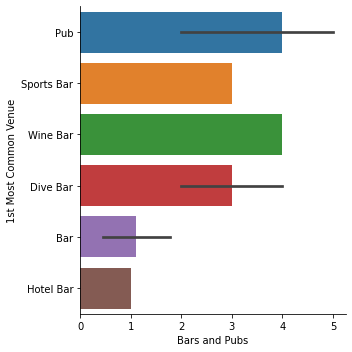

In [40]:
sns.catplot(x='Bars and Pubs', y='1st Most Common Venue', data=boston_merged, kind='bar')

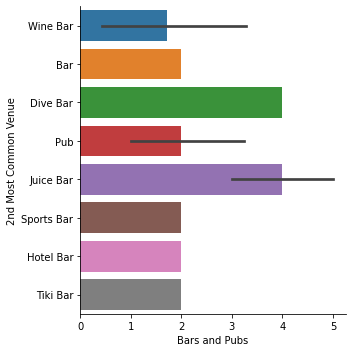

In [41]:
sns.catplot(x='Bars and Pubs', y='2nd Most Common Venue', data=boston_merged, kind='bar')

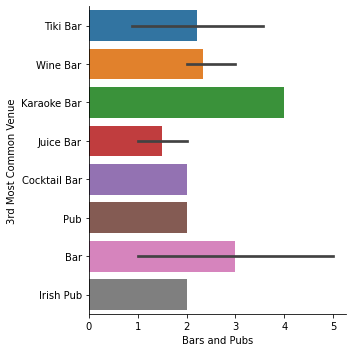

In [42]:
sns.catplot(x='Bars and Pubs', y='3rd Most Common Venue', data=boston_merged, kind='bar')

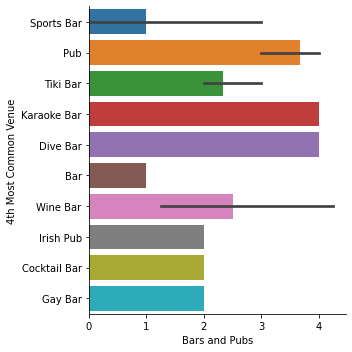

In [43]:
sns.catplot(x='Bars and Pubs', y='4th Most Common Venue', data=boston_merged, kind='bar')

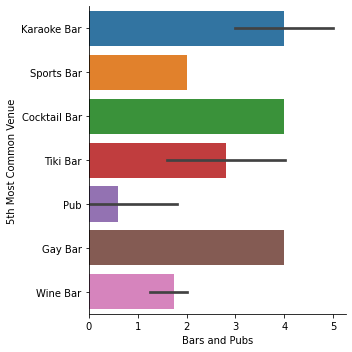

In [44]:
sns.catplot(x='Bars and Pubs', y='5th Most Common Venue', data=boston_merged, kind='bar')

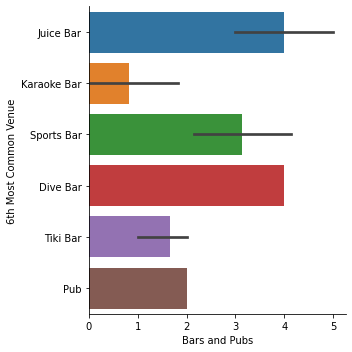

In [45]:
sns.catplot(x='Bars and Pubs', y='6th Most Common Venue', data=boston_merged, kind='bar')

<table>
<thead>
<tr>
<th>Cluster</th>
<th>Most Common Bars</th>
<th>Least Common Bars</th>
<th>2nd Least Common Bars</th>
</tr>
</thead>
<tbody>
<tr>
<td>1</td>
<td>Bars and Pubs</td>
<td>French</td>
<td>Filipino</td>
</tr>
<tr>
<td>2</td>
<td>English</td>
<td>German</td>
<td>French</td>
</tr>
<tr>
<td>3</td>
<td>Depends on neighborhood</td>
<td>Depends on neighborhood</td>
<td>Depends on neighborhood</td>
</tr>
<tr>
<td>4</td>
<td>Turkish</td>
<td>French</td>
<td>Filipino</td>
</tr>
<tr>
<td>5</td>
<td>Indian</td>
<td>French</td>
<td>Falafel</td>
</tr>
<tr>
<td>6</td>
<td>Italian</td>
<td>French</td>
<td>Fast Food</td>
<tr>
</tr>
</tbody>
</table>

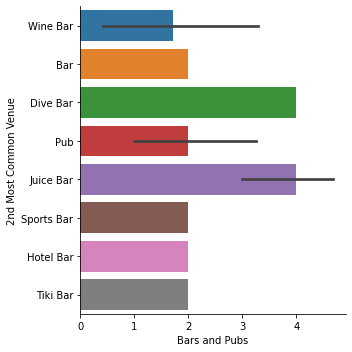

In [45]:
sns.catplot(x='Bars and Pubs', y='2nd Most Common Venue', data=boston_merged, kind='bar')

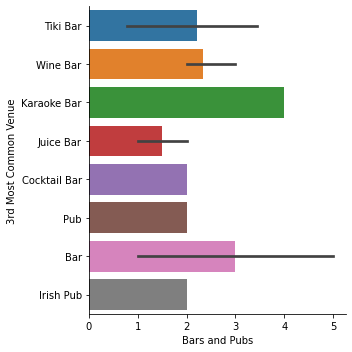

In [46]:
sns.catplot(x='Bars and Pubs', y='3rd Most Common Venue', data=boston_merged, kind='bar')

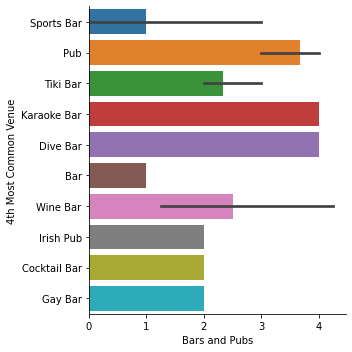

In [47]:
sns.catplot(x='Bars and Pubs', y='4th Most Common Venue', data=boston_merged, kind='bar')

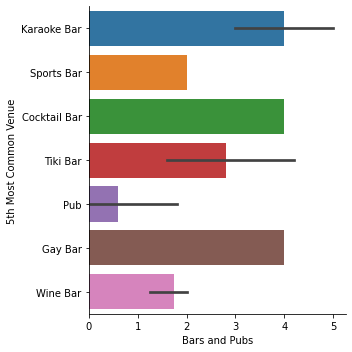

In [48]:
sns.catplot(x='Bars and Pubs', y='5th Most Common Venue', data=boston_merged, kind='bar')

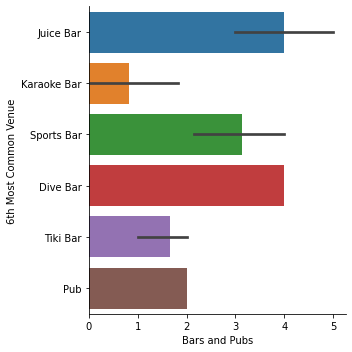

In [49]:
sns.catplot(x='Bars and Pubs', y='6th Most Common Venue', data=boston_merged, kind='bar')

<table>
<thead>
<tr>
<th>Cluster</th>
<th>Most Common Restaurant</th>
<th>Least Common Restaurant</th>
<th>2nd Least Common Restaurant</th>
</tr>
</thead>
<tbody>
<tr>
<td>1</td>
<td>Chinese and Xinjiang</td>
<td>French</td>
<td>Filipino</td>
</tr>
<tr>
<td>2</td>
<td>English</td>
<td>German</td>
<td>French</td>
</tr>
<tr>
<td>3</td>
<td>Depends on neighborhood</td>
<td>Depends on neighborhood</td>
<td>Depends on neighborhood</td>
</tr>
<tr>
<td>4</td>
<td>Turkish</td>
<td>French</td>
<td>Filipino</td>
</tr>
<tr>
<td>5</td>
<td>Indian</td>
<td>French</td>
<td>Falafel</td>
</tr>
<tr>
<td>6</td>
<td>Italian</td>
<td>French</td>
<td>Fast Food</td>
</tr>
<tr>
<td>7</td>
<td>table</td>
<td>French</td>
<td>Filipino</td>
</tr>
<tr>
<td>8</td>
<td>table</td>
<td>French</td>
<td>Filipino</td>
</tr>
</tbody>
</table>
